In [9]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# call ARIMA (includes sarima/sarimax) model
from statsmodels.tsa.arima.model import ARIMA

## another SARIMAX implementation from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

# load inflow dataset into dataframe
#inflow_data = pd.read_excel("../InflowData_1.xlsx")
inflow_data = pd.read_csv("../inflow_imputed.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
#inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")
inflow_data.index = pd.to_datetime(inflow_data.index)

# # print first two rows
# inflow_data.head(3)

In [10]:
# weather data
weather_data = pd.read_csv("../weather_imputed.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index)

In [11]:
# create an utility metric function
def print_metrics(y_obs,y_pred, model_name,return_df=None):
    MeanAE_24h = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    MaxAE_24h = np.max(np.abs(y_obs[0:24] - y_pred[0:24]))

    MeanAE_144h = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    total_sum = np.sum(MeanAE_24h + MaxAE_24h + MeanAE_144h)

    dict_ = {'MeanAE-24h': MeanAE_24h, 'MaxAE-24h': MaxAE_24h,
             'MeanAE-144h': MeanAE_144h, 'Total': total_sum}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    print(model_name)
    print(f"MeanAE-24h      MaxAE-24h      MeanAE-144h      Total")
    print(f"{MeanAE_24h:.2f}            {MaxAE_24h:.2f}             {MeanAE_144h:.2f}           {total_sum:.2f} \n")
    if return_df == 1:
        return(df.round(decimals = 3))

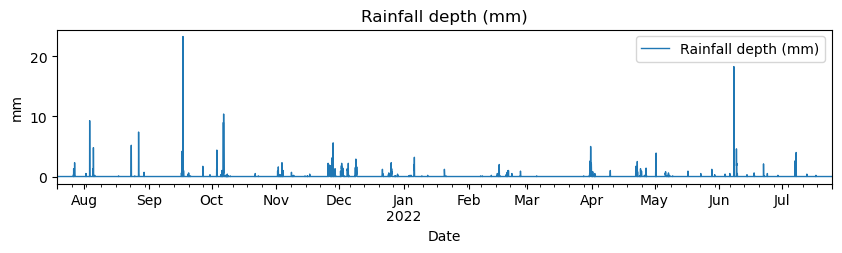

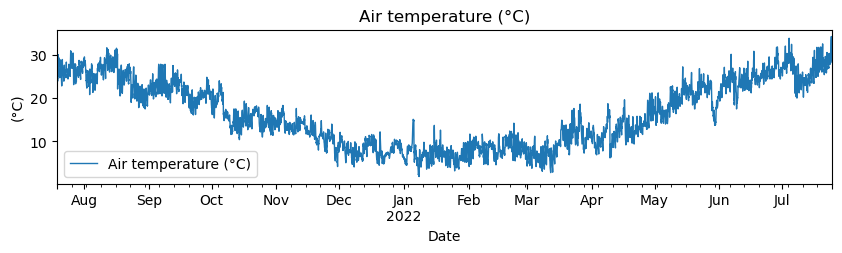

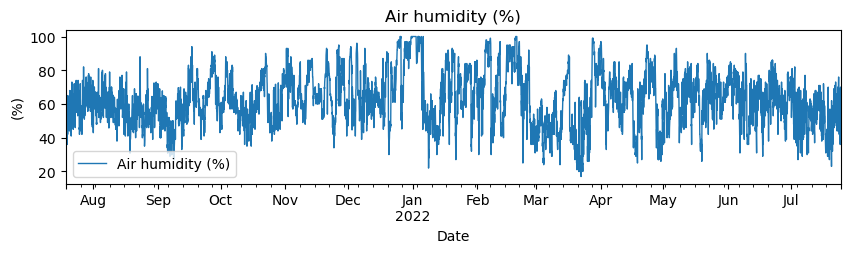

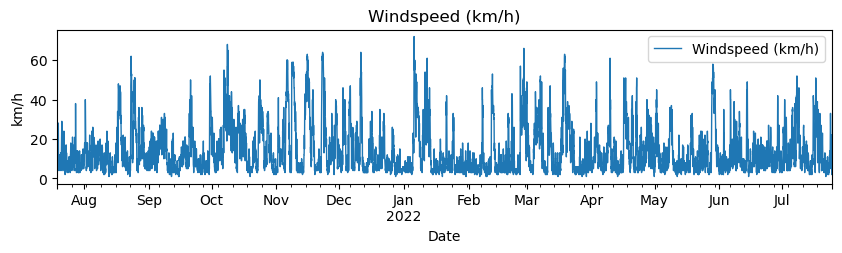

In [12]:
# define start and end dates for analysis (last week is used for evaluation)
start = '2021-07-19'
end = '2022-07-24'

# make feature time series dataframe
tseriesX_df = weather_data.copy()

## add weekened and holidays as exogenous variable (one hot encoded)
# tseriesX_df['weekend (0/1)'] = 0
# tseriesX_df[0:24] = 1
# tseriesX_df[144:192] = 1
# tseriesX_df[312:360] = 1

# reduce time series to specified start and end dates
tseriesX_df = tseriesX_df[start:end].copy()

# make train and test sets
X = tseriesX_df
X_train, X_test = temporal_train_test_split(X, test_size=168)

# fill missing values with interpolation technique
#tseriesX_df.interpolate(limit_direction='both',inplace=True)

## visualize weather data

# RAINFALL
var = 'Rainfall depth (mm)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("mm")
plt.legend()
plt.show()

# AIR TEMPERATURE
var = 'Air temperature (°C)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(°C)")
plt.legend()
plt.show()

# AIR HUMIDITY
var = 'Air humidity (%)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(%)")
plt.legend()
plt.show()

# WINDSPEED
var = 'Windspeed (km/h)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("km/h")
plt.legend()
plt.show()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92775D+00    |proj g|=  1.94637D-01

At iterate    5    f=  1.84757D+00    |proj g|=  9.13447D-02

At iterate   10    f=  1.79454D+00    |proj g|=  7.20910D-02

At iterate   15    f=  1.78865D+00    |proj g|=  2.42418D-02

At iterate   20    f=  1.78854D+00    |proj g|=  5.51354D-03

At iterate   25    f=  1.78833D+00    |proj g|=  1.92205D-03

At iterate   30    f=  1.78813D+00    |proj g|=  8.68015D-03

At iterate   35    f=  1.78776D+00    |proj g|=  8.85675D-03

At iterate   40    f=  1.78716D+00    |proj g|=  6.00781D-03

At iterate   45    f=  1.78623D+00    |proj g|=  3.59488D-02

At iterate   50    f=  1.78265D+00    |proj g|=  1.10072D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

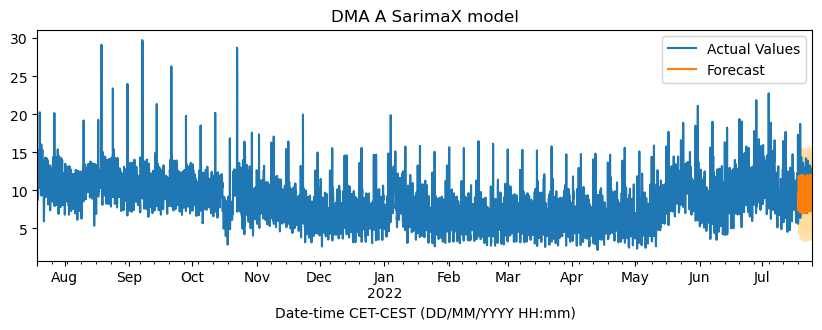

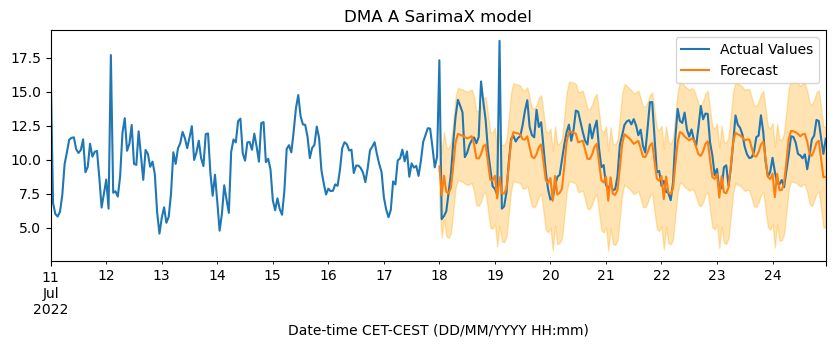

Performance indicators
DMA A SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.84            7.81             1.16           10.81 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
3.25            8.61             2.48           14.34 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.50811D-01    |proj g|=  4.01182D-01

At iterate    5    f=  7.30212D-01    |proj g|=  1.35038D-01

At iterate   10    f=  6.75773D-01    |proj g|=  3.64157D-01

At iterate   15    f=  6.69782D-01    |proj g|=  2.56874D-02

At iterate   20    f=  6.69685D-01    |proj g|=  3.27137D-03

At iterate   25    f=  6.69677D-01    |proj g|=  1.63077D-03

At iterate   30    f=  6.69677D-01    |proj g|=  2.10327D-03

At iterate   35    f=  6.69671D-01    |proj g|=  5.12777D-03

At iterate   40    f=  6.69667D-01    |proj g|=  8.89074D-03

At iterate   45    f=  6.69653D-01    |proj g|=  5.30335D-03

At iterate   50    f=  6.69126D-01    |proj g|=  6.18095D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

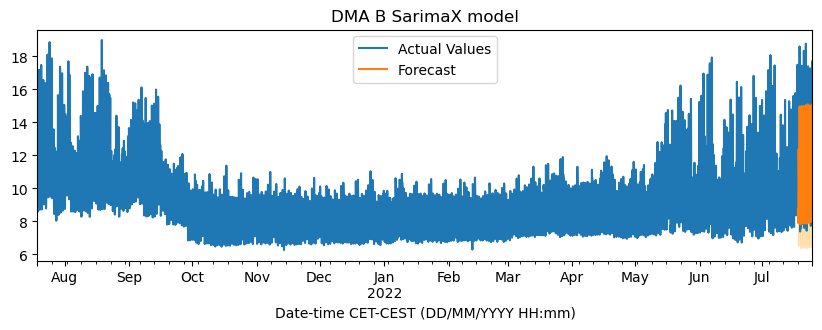

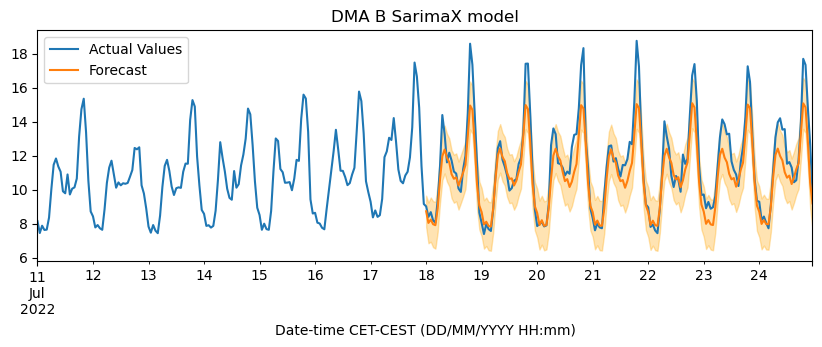

Performance indicators
DMA B SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.88            3.64             0.87           5.39 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.62            9.29             2.72           14.64 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07907D+00    |proj g|=  2.13924D+00


 This problem is unconstrained.



At iterate    5    f=  7.26054D-01    |proj g|=  1.31325D+00

At iterate   10    f=  4.90041D-01    |proj g|=  6.55305D-01

At iterate   15    f=  4.66102D-01    |proj g|=  2.75527D-01

At iterate   20    f=  4.48139D-01    |proj g|=  1.49492D-01

At iterate   25    f=  4.31810D-01    |proj g|=  4.45588D-01

At iterate   30    f=  4.30492D-01    |proj g|=  9.84702D-02

At iterate   35    f=  4.26916D-01    |proj g|=  2.16297D-01

At iterate   40    f=  4.25793D-01    |proj g|=  1.82726D-02

At iterate   45    f=  4.25691D-01    |proj g|=  9.36821D-03

At iterate   50    f=  4.25686D-01    |proj g|=  7.85931D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

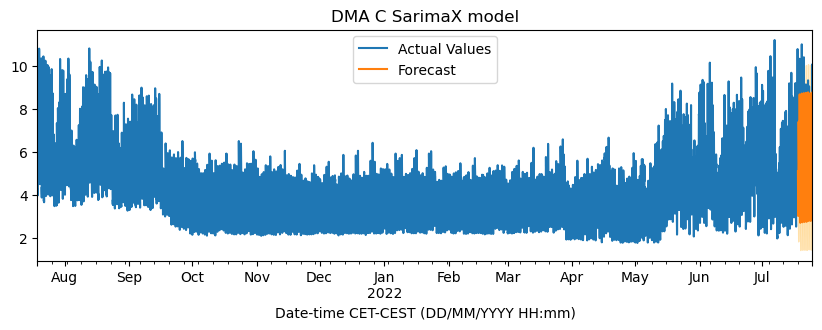

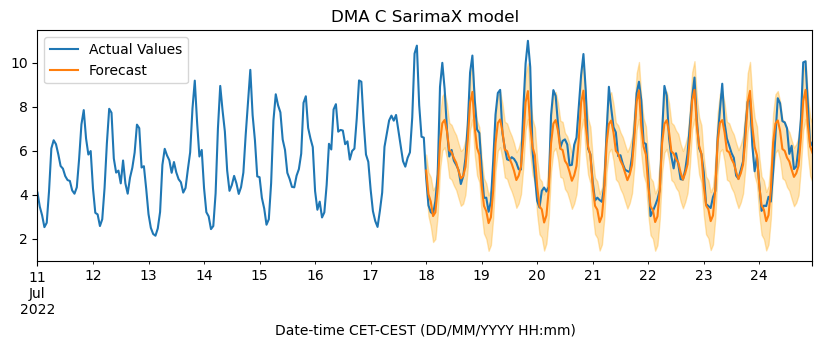

Performance indicators
DMA C SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.73            2.74             0.63           4.10 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.22            5.98             2.01           10.21 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43631D+00    |proj g|=  8.99099D-02

At iterate    5    f=  2.34248D+00    |proj g|=  4.46582D-02

At iterate   10    f=  2.32731D+00    |proj g|=  4.71116D-02

At iterate   15    f=  2.32553D+00    |proj g|=  3.68627D-03

At iterate   20    f=  2.32540D+00    |proj g|=  2.95289D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     23     29      1     0     0   3.902D-04   2.325D+00
  F =   2.3254011889960871     

CONVERG

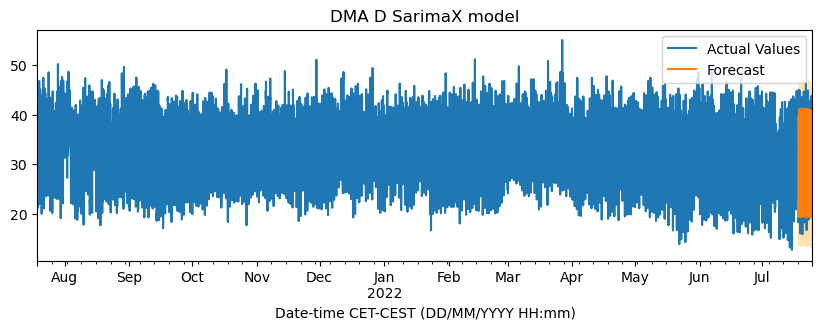

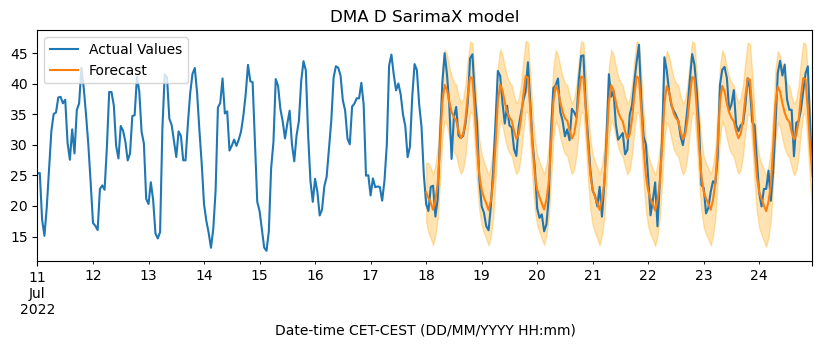

Performance indicators
DMA D SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.31            7.71             2.32           12.34 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
6.76            15.00             6.45           28.22 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52864D+00    |proj g|=  1.01652D-01


 This problem is unconstrained.



At iterate    5    f=  2.43769D+00    |proj g|=  2.37991D-01

At iterate   10    f=  2.41961D+00    |proj g|=  2.35224D-02

At iterate   15    f=  2.41902D+00    |proj g|=  2.41711D-03

At iterate   20    f=  2.41890D+00    |proj g|=  1.66384D-02

At iterate   25    f=  2.41883D+00    |proj g|=  4.28057D-03

At iterate   30    f=  2.41882D+00    |proj g|=  3.58277D-04

At iterate   35    f=  2.41882D+00    |proj g|=  2.77952D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     37     43      1     0     0   2.760D-04   2.419D+00
  F =   2.4188208190778662     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

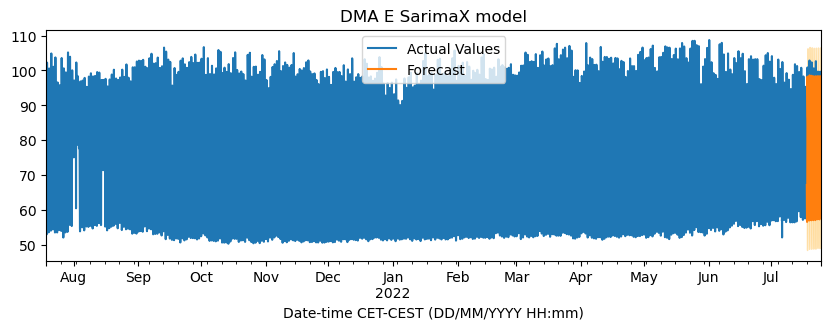

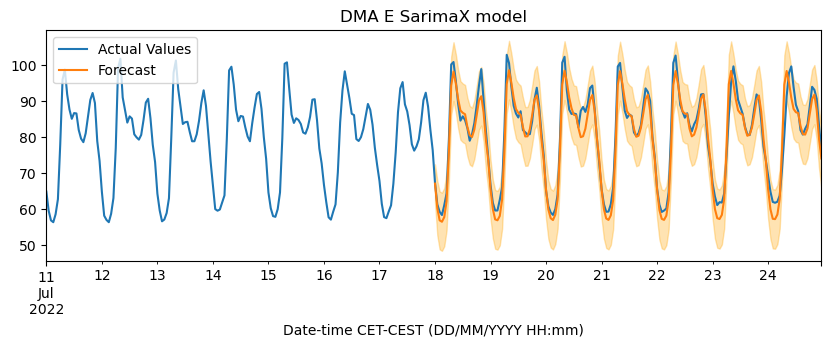

Performance indicators
DMA E SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.32            7.53             2.36           12.21 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
11.87            23.93             11.51           47.31 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51557D+00    |proj g|=  2.72276D-01


 This problem is unconstrained.



At iterate    5    f=  1.46371D+00    |proj g|=  9.58311D-02

At iterate   10    f=  1.43412D+00    |proj g|=  5.72196D-01

At iterate   15    f=  1.42236D+00    |proj g|=  6.62539D-02

At iterate   20    f=  1.42019D+00    |proj g|=  1.40180D-01

At iterate   25    f=  1.41944D+00    |proj g|=  1.20700D-02

At iterate   30    f=  1.41708D+00    |proj g|=  7.06500D-02

At iterate   35    f=  1.41689D+00    |proj g|=  2.23534D-02

At iterate   40    f=  1.41679D+00    |proj g|=  1.66011D-03

At iterate   45    f=  1.41676D+00    |proj g|=  3.75648D-02

At iterate   50    f=  1.41646D+00    |proj g|=  3.54955D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

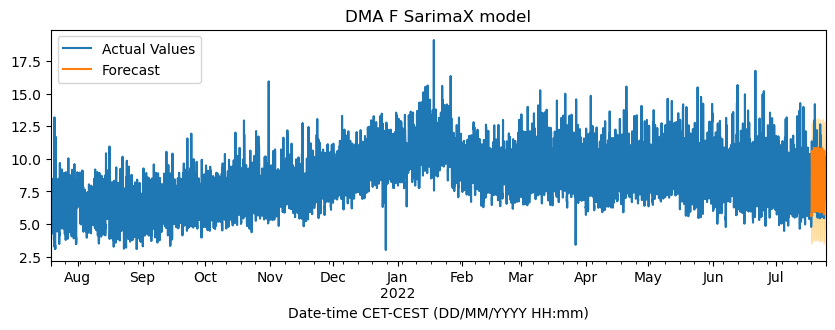

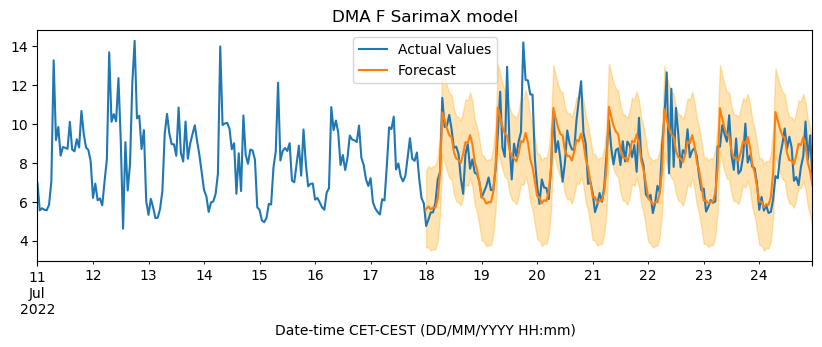

Performance indicators
DMA F SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.58            2.05             0.91           3.54 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.48            3.63             1.38           6.49 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87069D+00    |proj g|=  1.17534D-01

At iterate    5    f=  1.80289D+00    |proj g|=  1.60031D-01

At iterate   10    f=  1.75948D+00    |proj g|=  1.15552D-02

At iterate   15    f=  1.75877D+00    |proj g|=  3.63540D-03

At iterate   20    f=  1.75875D+00    |proj g|=  5.26835D-04

At iterate   25    f=  1.75874D+00    |proj g|=  2.83987D-03

At iterate   30    f=  1.75873D+00    |proj g|=  3.33581D-03

At iterate   35    f=  1.75872D+00    |proj g|=  1.45947D-03

At iterate   40    f=  1.75872D+00    |proj g|=  2.86765D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

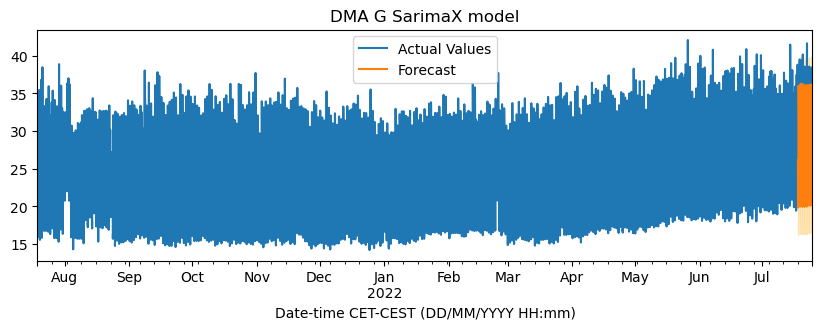

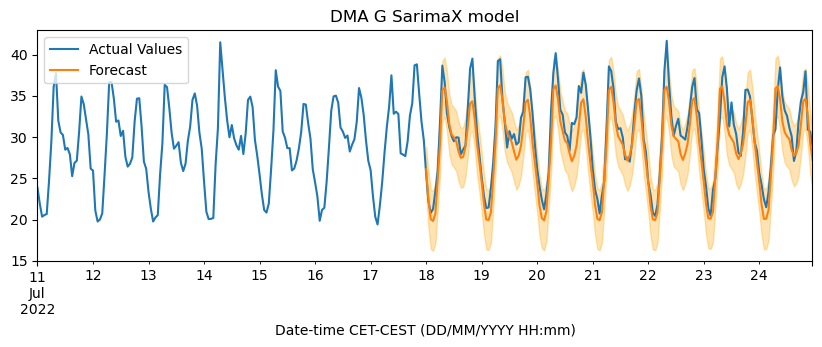

Performance indicators
DMA G SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.50            5.16             1.88           8.55 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
5.95            14.41             6.27           26.64 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09494D+00    |proj g|=  1.33678D+00


 This problem is unconstrained.



At iterate    5    f=  1.61237D+00    |proj g|=  2.62692D-01

At iterate   10    f=  1.54399D+00    |proj g|=  3.38209D-01

At iterate   15    f=  1.50198D+00    |proj g|=  3.52802D-02

At iterate   20    f=  1.49666D+00    |proj g|=  3.47733D-02

At iterate   25    f=  1.49473D+00    |proj g|=  8.12932D-03

At iterate   30    f=  1.49470D+00    |proj g|=  1.07787D-03

At iterate   35    f=  1.49469D+00    |proj g|=  1.21255D-03

At iterate   40    f=  1.49465D+00    |proj g|=  5.98244D-03

At iterate   45    f=  1.49401D+00    |proj g|=  2.74563D-02

At iterate   50    f=  1.48936D+00    |proj g|=  4.52641D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

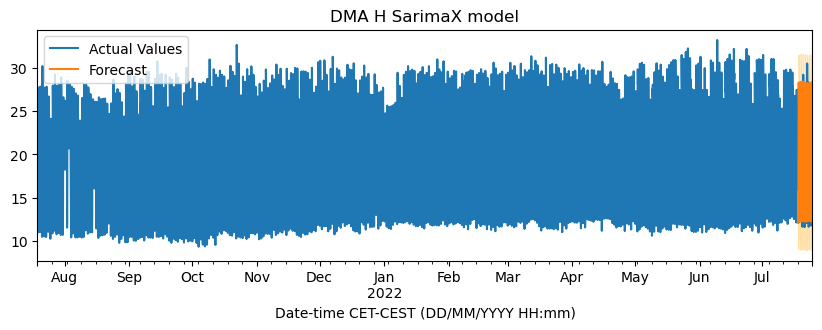

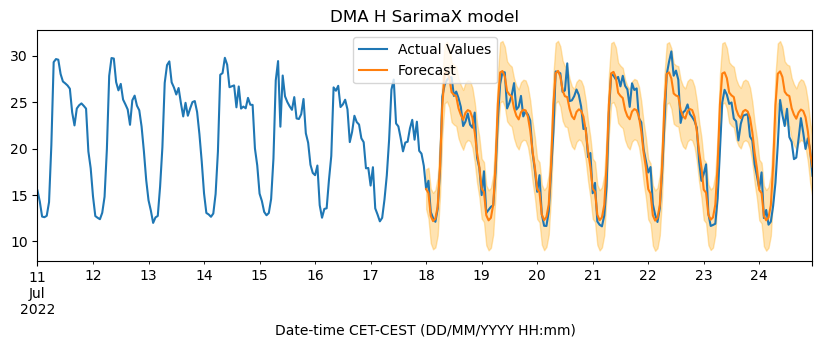

Performance indicators
DMA H SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.73            2.11             1.48           4.32 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.70            8.55             4.59           17.84 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90353D+00    |proj g|=  1.64632D-01


 This problem is unconstrained.



At iterate    5    f=  1.81423D+00    |proj g|=  1.06775D-01

At iterate   10    f=  1.76483D+00    |proj g|=  3.94972D-02

At iterate   15    f=  1.76060D+00    |proj g|=  1.39147D-02

At iterate   20    f=  1.76013D+00    |proj g|=  3.59256D-03

At iterate   25    f=  1.76006D+00    |proj g|=  2.77633D-03

At iterate   30    f=  1.75999D+00    |proj g|=  1.34647D-03

At iterate   35    f=  1.75997D+00    |proj g|=  1.50209D-03

At iterate   40    f=  1.75992D+00    |proj g|=  7.00510D-03

At iterate   45    f=  1.75978D+00    |proj g|=  6.75206D-03

At iterate   50    f=  1.75944D+00    |proj g|=  5.19709D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

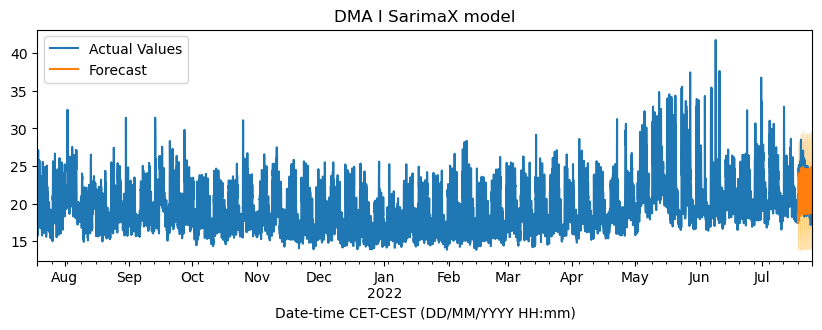

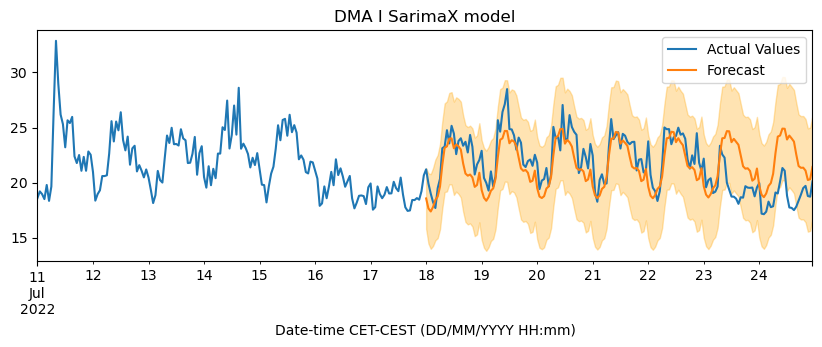

Performance indicators
DMA I SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.44            3.59             1.75           6.79 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.94            5.60             2.49           11.04 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92887D+00    |proj g|=  1.45330D-01

At iterate    5    f=  1.83546D+00    |proj g|=  1.36673D-01

At iterate   10    f=  1.78368D+00    |proj g|=  4.91237D-02

At iterate   15    f=  1.78225D+00    |proj g|=  1.33173D-02

At iterate   20    f=  1.78222D+00    |proj g|=  1.10244D-03

At iterate   25    f=  1.78221D+00    |proj g|=  2.67716D-03

At iterate   30    f=  1.78220D+00    |proj g|=  3.56645D-03

At iterate   35    f=  1.78217D+00    |proj g|=  5.73501D-03

At iterate   40    f=  1.78212D+00    |proj g|=  1.79255D-03

At iterate   45    f=  1.78208D+00    |proj g|=  1.96903D-03

At iterate   50    f=  1.78199D+00    |proj g|=  3.49448D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

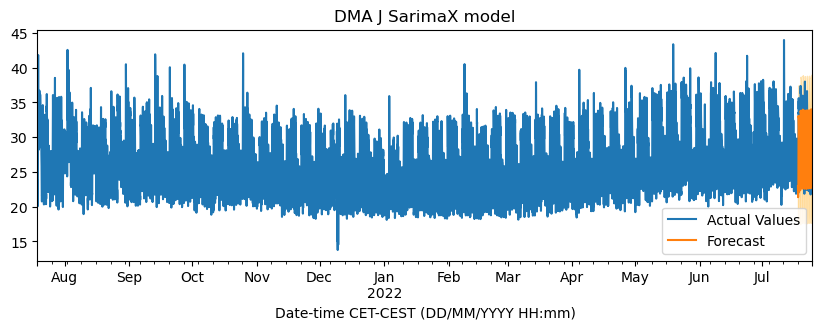

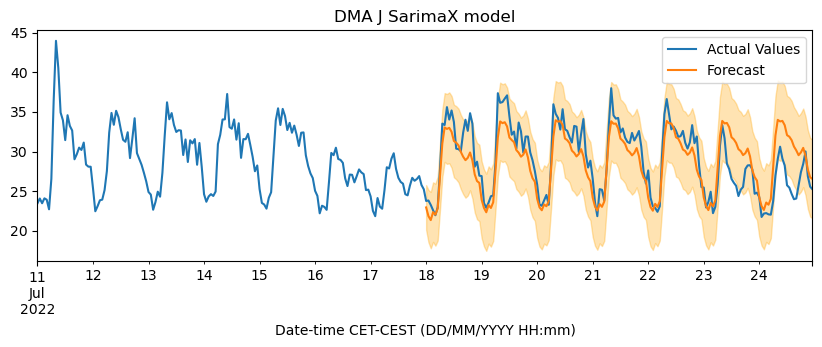

Performance indicators
DMA J SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.86            5.10             2.05           9.01 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.97            9.16             4.03           18.17 



In [13]:
# make empty datafram to store results
results_df = pd.DataFrame()

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

# select dma for analysis
for dma in list(inflow_data.columns):
    
    # copy data from dataframe in a new time series dataframe
    tseries_df = inflow_data[dma][start:end].copy()

    # fill missing values with interpolation technique
    #tseries_df.interpolate(limit_direction='both',inplace=True)

    # # plot original and interpolated time series for selected dma
    # fig, ax = plt.subplots()
    # tseries_df.plot(label='Interpolated')
    # inflow_data[dma][start:end].plot(y=dma_list[i],use_index=True,ax = ax,figsize=(25,5), linewidth=1, label='Original')
    # plt.title(dma_list[dict_dma[dma]] + ". " + dma_descripton[dict_dma[dma]] +". "+ str(users_supplied[dict_dma[dma]]) + " users supplied. ")
    # plt.xlabel("Date")
    # plt.ylabel("L/s")
    # plt.legend()
    # plt.show()

    # demand time series
    y = tseries_df
    y_train, y_test = temporal_train_test_split(y, test_size = 168)

    # exogenous variables time series
    X = tseriesX_df
    X_train, X_test = temporal_train_test_split(X, test_size=168)

    #Naive Forecaster
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster = NaiveForecaster(strategy = 'mean')
    forecaster.fit(y_train)
    # results of naive forecaster
    y_pred_naive = forecaster.predict(fh)

    # #print results (optional)
    # fig, ax = plt.subplots(figsize = (10,3))
    # tseries_df.plot(title = 'Naive Forecaster', ax = ax)
    # y_pred_naive.plot(ax = ax)
    # ax.legend(['Actual Values', 'Forecast'])
    # plt.show()

    # implement sarimaX model    
    # the statsmodel package applies the difference already if needed.

    model = SARIMAX(y_train, exog=X_train, order=(2,0,2), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
    model_fit = model.fit()
    # print(model_fit.summary())

    y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)

    # plot forecast and full time series length
    fig, ax = plt.subplots(figsize = (10,3))
    tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
    y_pred.plot(y='mean',ax = ax)
    ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
    ax.legend(['Actual Values', 'Forecast'])
    plt.show()

    # plot forecast and last two weeks of time series
    fig, ax = plt.subplots(figsize = (10,3))
    tseries_df['2022-07-11':'2022-07-24'].plot(title = dma[:5]+' SarimaX model', ax = ax)
    y_pred.plot(y='mean',ax = ax)
    ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
    ax.legend(['Actual Values', 'Forecast'])
    plt.show()

    print('Performance indicators')
    df = print_metrics(y_test, y_pred['mean'], dma[:5]+' SarimaX 52-Weeks',return_df=1)
    results_df = pd.concat([results_df, df])
    print_metrics(y_test, y_pred_naive, 'Naive Forecaster')

In [14]:
results_df

,MeanAE-24h,MaxAE-24h,MeanAE-144h,Total
DMA A SarimaX 52-Weeks,1.840,7.811,1.159,10.810
DMA B SarimaX 52-Weeks,0.877,3.639,0.869,5.385
DMA C SarimaX 52-Weeks,0.725,2.745,0.632,4.102
DMA D SarimaX 52-Weeks,2.309,7.714,2.319,12.343
DMA E SarimaX 52-Weeks,2.320,7.526,2.364,12.209
DMA F SarimaX 52-Weeks,0.579,2.052,0.909,3.540
DMA G SarimaX 52-Weeks,1.502,5.161,1.884,8.547
DMA H SarimaX 52-Weeks,0.732,2.109,1.483,4.324
DMA I SarimaX 52-Weeks,1.443,3.591,1.752,6.785
DMA J SarimaX 52-Weeks,1.857,5.102,2.053,9.012


In [15]:
print(f"{results_df['Total'].sum() :.2f}")

77.06


In [18]:
print(f"{results_df.drop('DMA E SarimaX 52-Weeks')['Total'].sum() :.2f}")

64.85
